## ✈️ Budapest Airspace Flight Analysis — Technological Demo

This project is a technological demonstration focused on geospatial data analysis and visualization using flight data from the Flightradar24 API. It showcases a complete pipeline from data acquisition to insightful visualizations, specifically targeting flights that intersect with Budapest's airspace.

### Key Components of the Demo:
- **Data Acquisition**: We demonstrate how to fetch historical flight data using the Flightradar24 API, including handling authentication and timestamped queries.
- **Geospatial Filtering**: To ensure relevance, we apply a bounding box around Budapest and filter incoming data to include only flights within this geographic boundary.
- **Territory Representation**: We identify and construct a polygon that accurately represents the geolocation of Budapest, allowing for precise spatial analysis.
- **Spatial Inclusion Logic**: Each flight's position is evaluated to determine whether it falls within the Budapest polygon, enabling us to isolate flights that truly entered the city's airspace.
- **Analysis & Visualization**: Using the filtered dataset, we perform various analyses such as flight frequency by hour and day of the week, and visualize these patterns using clear, informative charts.

This demo blends API integration, geospatial logic, and data visualization to explore air traffic dynamics over Budapest in a reproducible and scalable way.

markdown
### 📦 Import Libraries and Configure Display Settings

This cell imports all necessary libraries for geospatial analysis, data visualization, and API interaction. It also configures pandas to display all columns and rows, which helps during exploratory data analysis and debugging.

In [15]:
# Import core libraries for mapping, time handling, and data processing
import folium                # For interactive maps
import datetime              # For timestamp generation
import requests              # For API calls
import pandas as pd          # For data manipulation
import time                  # For rate-limiting API requests
import geopandas as gpd      # For geospatial operations
from shapely.geometry import Point  # For geometric calculations
from IPython.display import HTML
from IPython.display import Image, display

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Configure pandas to display all columns and rows in outputs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### 📍 Visualizing the Geographic Boundary of Budapest

This cell defines a bounding box around Budapest using latitude and longitude coordinates. It then creates an interactive Folium map centered on this region, draws a shaded rectangle to represent the boundary, and places markers at the southwest and northeast corners. This visualization helps confirm the spatial area used for filtering flight data.

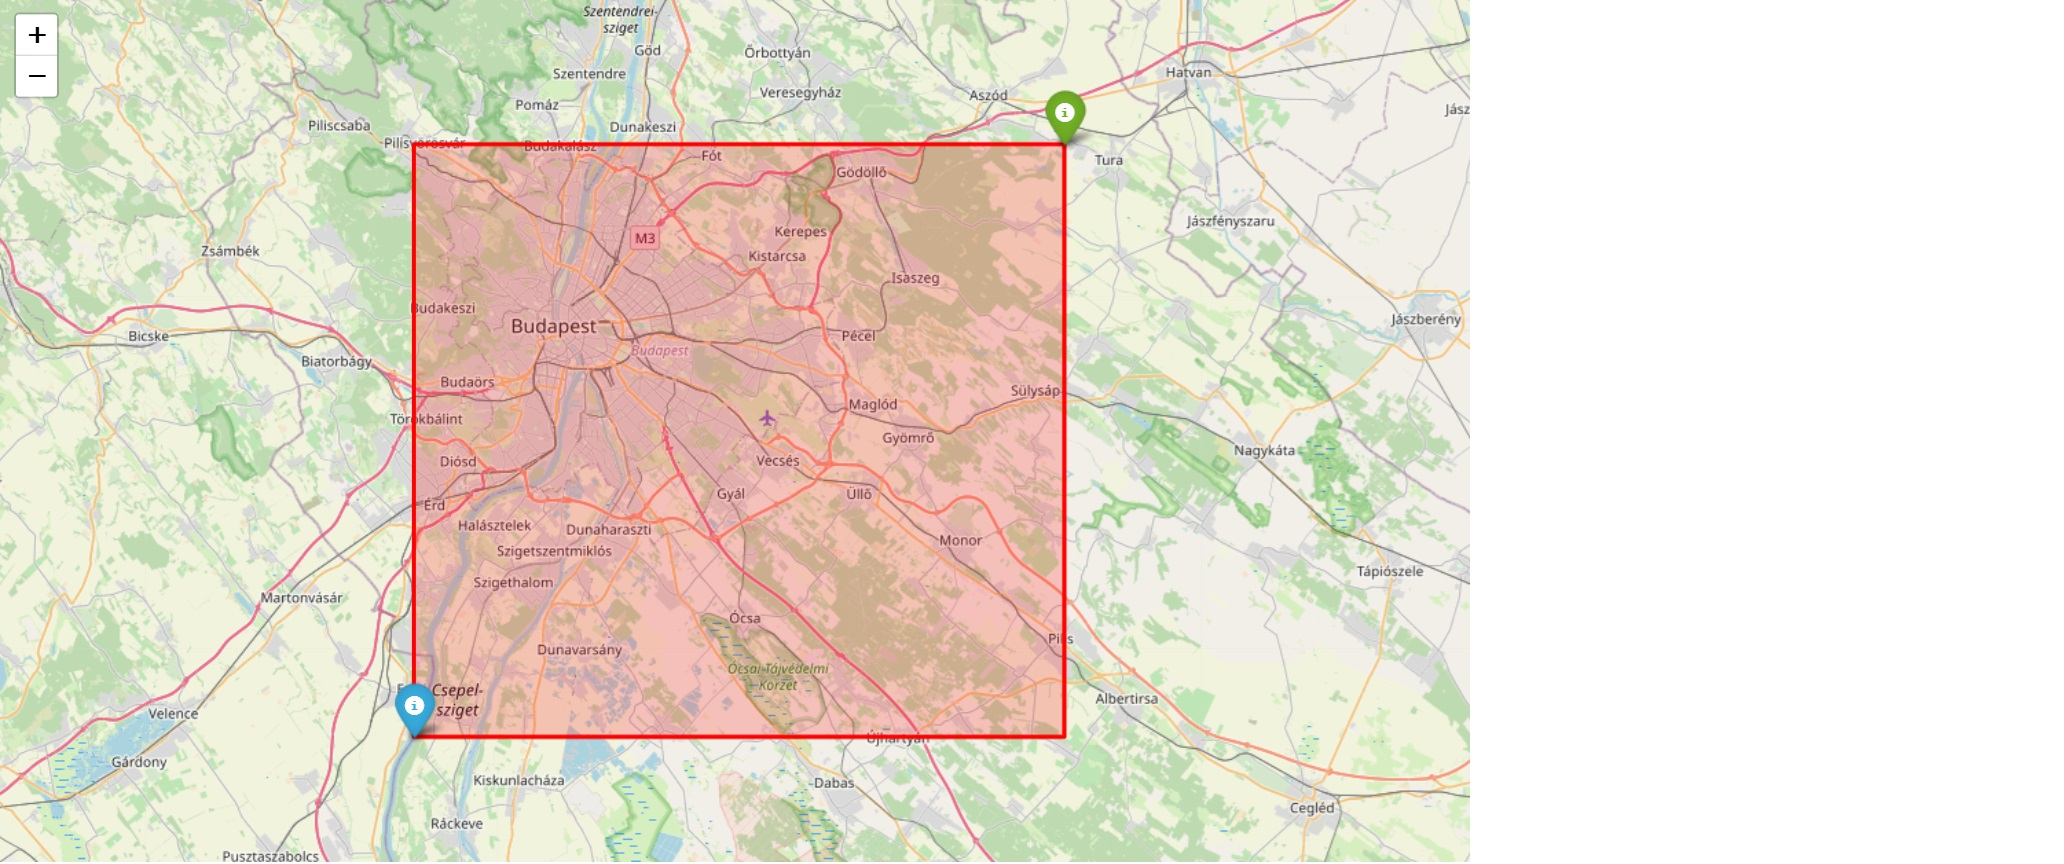

In [18]:
# Define the southwest and northeast corners of Budapest's bounding box
outer_bound_southwest = [47.22, 18.9]
outer_bound_northeast = [47.62, 19.55]

# Calculate the center point of the bounding box for map centering
outer_bound_center_lat = (outer_bound_southwest[0] + outer_bound_northeast[0]) / 2
outer_bound_center_lon = (outer_bound_southwest[1] + outer_bound_northeast[1]) / 2

# Initialize a Folium map centered over Budapest
map_bp_bounded = folium.Map(location=[outer_bound_center_lat, outer_bound_center_lon], zoom_start=10)

# Add a shaded rectangle to visualize the bounding box
folium.Rectangle(
    bounds=[outer_bound_southwest, outer_bound_northeast],
    color='red',
    fill=True,
    fill_opacity=0.2,
    tooltip='Boundary of Budapest'
).add_to(map_bp_bounded)

# Place a marker at the southwest corner
folium.Marker(
    location=outer_bound_southwest,
    popup=f"SW Corner: {outer_bound_southwest[0]}, {outer_bound_southwest[1]}",
    icon=folium.Icon(color='blue', icon='info-sign')
).add_to(map_bp_bounded)

# Place a marker at the northeast corner
folium.Marker(
    location=outer_bound_northeast,
    popup=f"NE Corner: {outer_bound_northeast[0]}, {outer_bound_northeast[1]}",
    icon=folium.Icon(color='green', icon='info-sign')
).add_to(map_bp_bounded)

# Display the interactive map
map_bp_bounded

# Display the image on GitHUB, because it doesn't render folium maps directly
display(Image(filename="map_bp_bounded.jpg"))

### 🔄 Fetching Historical Flight Data from Flightradar24 API

This function retrieves flight position data from the Flightradar24 API for a specified bounding box around Budapest. It generates timestamps at 10-minute intervals over a one-week period, queries the API for each timestamp, and collects flights within a specified altitude range. The results are stored in a DataFrame and saved to a CSV file for further analysis.

In [3]:
def retrieve_flight_data(api_key, outer_bound_northeast, outer_bound_southwest):
    # Format bounding box as required by the API: [north, south, west, east]
    outer_bounds = f"{outer_bound_northeast[0]},{outer_bound_southwest[0]},{outer_bound_southwest[1]},{outer_bound_northeast[1]}"

    # Set up request headers with API key
    headers = {
        "Accept": "application/json",
        "Accept-Version": "v1",
        "Authorization": f"Bearer {api_key}"
    }

    # Define time range and interval for data collection
    start = datetime.datetime(2025, 8, 10, 0, 0)
    end = datetime.datetime(2025, 8, 17, 0, 0)
    delta = datetime.timedelta(minutes=10)

    # Generate list of UNIX timestamps at 10-minute intervals
    timestamps = [int((start + i * delta).timestamp()) for i in range(int((end - start) / delta))]

    # Define altitude range filter
    altitude_ranges = '20-100000'

    # Initialize list to store all flight records
    all_flights = []

# Loop through each timestamp and query the API
    for ts in timestamps:
        url = f"https://fr24api.flightradar24.com/api/historic/flight-positions/full?bounds={outer_bounds}&timestamp={ts}&altitude_ranges={altitude_ranges}"
        print(url)

        # Uncomment the line below to activate the API call
        # response = requests.get(url, headers=headers)

        if response.status_code == 200:
            flights = response.json().get('data', [])
            for flight in flights:
                flight['queried_timestamp'] = ts  # Tag each flight with its query time
            all_flights.extend(flights)
            print(f"✅ Retrieved {len(flights)} flights at timestamp {ts}")
        else:
            print(f"⚠️ Request failed at timestamp {ts} with status code {response.status_code}")

        # Pause to respect API rate limits (1 request every 6 seconds)
        time.sleep(6)

    # Convert collected flight data to a DataFrame
    df = pd.DataFrame(all_flights)
    print(f"📊 Total flights collected: {len(df)}")

    # Save the DataFrame to a CSV file
    filename = "budapest_airspace_flights_2025-08-10_2025-08-16.csv"
    df.to_csv(filename, index=False)
    print(f"💾 Data saved to {filename}")

    return None

### 🗂️ Load Flight Data and Identify Entries Within Budapest Airspace

This cell loads the previously saved flight data from a CSV file and reads a geographic boundary file for Hungary. It filters the boundary data to isolate Budapest and extracts its polygon geometry. Each flight's coordinates are then checked to determine whether it falls within Budapest's airspace. The timestamp is converted to local Budapest time, and additional temporal features like day of the week and hour of the day are extracted for further analysis.

In [4]:
# Load the CSV file into a DataFrame
df = pd.read_csv("budapest_airspace_flights_2025-08-10_2025-08-16.csv")

hu_gdf = gpd.read_file("hu.json")  # or .shp
hu_gdf = hu_gdf.to_crs(epsg=4326)

# Extract the geometry as a single Polygon
#hu_polygon = hu_gdf.geometry.unary_union

# Filter for Budapest
budapest_gdf = hu_gdf[hu_gdf['name'] == 'Budapest']

# Get the polygon geometry
budapest_polygon = budapest_gdf.geometry.values[0]

def is_inside_budapest(lat, lon):
    point = Point(lon, lat)  # Point(longitude, latitude)
    return budapest_polygon.contains(point)

# Apply and assign a single Boolean per row
df['in_budapest_airspace'] = df.apply(lambda row: is_inside_budapest(row['lat'], row['lon']), axis=1)
# Convert 'timestamp' to datetime with UTC timezone
df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
# Convert to Budapest local time (CEST during summer)
df["timestamp_budapest"] = df["timestamp"].dt.tz_convert("Europe/Budapest")
# Extract day of the week and hour of the day in Budapest time
df["day_of_week"] = df["timestamp_budapest"].dt.weekday
df["hour_of_day"] = df["timestamp_budapest"].dt.hour

df[["in_budapest_airspace", "day_of_week", "hour_of_day"]].head()

,in_budapest_airspace,day_of_week,hour_of_day
0,False,5,23
1,True,6,0
2,False,6,0
3,False,6,0
4,False,6,0


### 🗺️ Visualizing Flight Positions Relative to Budapest Airspace

This cell creates an interactive map to visually inspect whether flight positions fall within the defined Budapest airspace. Each flight is represented by a colored marker: green if the flight is inside the Budapest polygon, red if outside. This helps validate the spatial filtering logic and provides an intuitive overview of flight distribution.

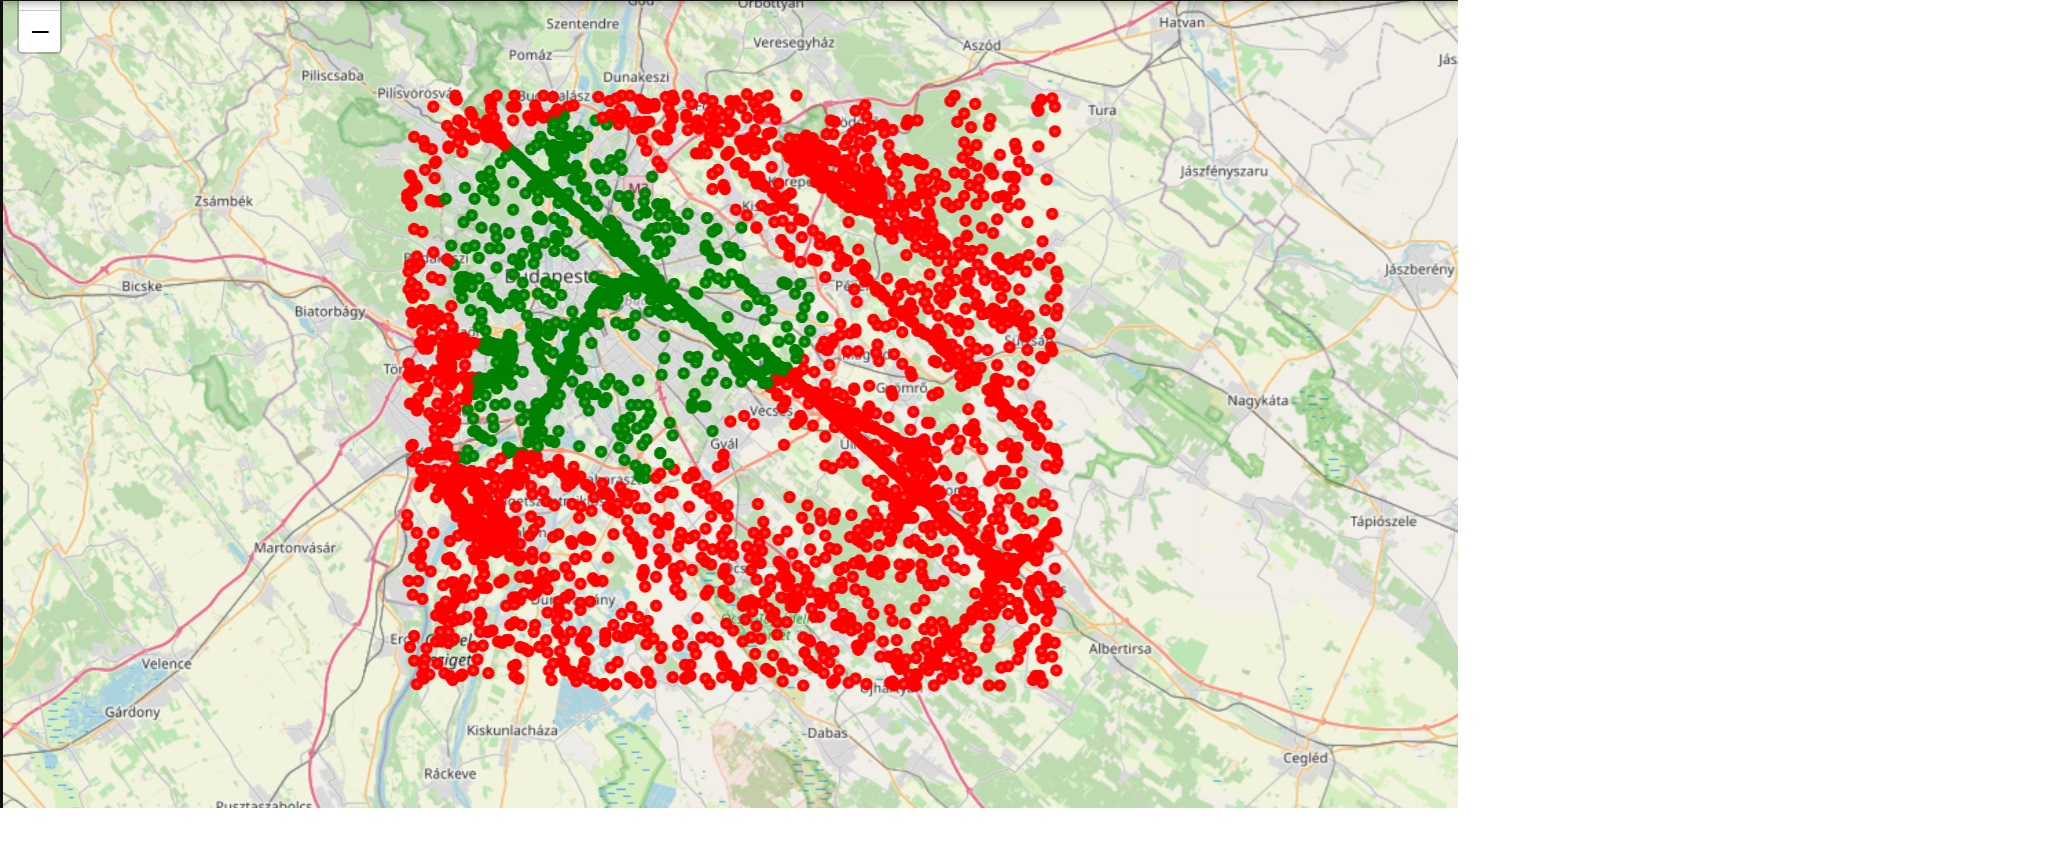

In [17]:
# Calculate the center of the bounding box for map centering
outer_bound_center_lat = (outer_bound_southwest[0] + outer_bound_northeast[0]) / 2
outer_bound_center_lon = (outer_bound_southwest[1] + outer_bound_northeast[1]) / 2

# Initialize a Folium map centered over Budapest
flight_map = folium.Map(location=[outer_bound_center_lat, outer_bound_center_lon], zoom_start=10)

# Plot each flight with altitude > 0 as a circle marker
for _, row in df[df["alt"] > 0].iterrows():
    # Use green for flights inside Budapest airspace, red for outside
    color = 'green' if row['in_budapest_airspace'] else 'red'
    
    # Add a circle marker for each flight
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=f"Flight ID: {row.get('id', 'N/A')}"
    ).add_to(flight_map)

# Display the interactive map
flight_map

# Display the image on GitHUB, because it doesn't render folium maps directly
display(Image(filename="flight_map.jpg"))

### ✈️ Filter and Aggregate Flights Over Budapest by Time

This cell filters the dataset to include only flights that entered Budapest's airspace. It then groups the filtered data by flight ID, day of the week, and hour of the day to count how many times each flight was recorded in each time slot. This aggregated data forms the basis for analyzing temporal flight patterns over Budapest.

In [6]:
# Filter the dataset to include only flights within Budapest airspace
df_over_budapest = df[df["in_budapest_airspace"] == True]

# Group by flight ID, day of week, and hour of day to count flight occurrences
df_flight_by_day_hour = (
    df_over_budapest
    .groupby(["fr24_id", "day_of_week", "hour_of_day"])
    .size()
    .reset_index(name="flight_count")  # Create a column for the count
)

### 📊 Aggregate Distinct Flights by Hour and Day of the Week

This cell calculates the number of distinct flights that entered Budapest's airspace, grouped by hour of the day and day of the week. It ensures uniqueness by grouping first by flight ID, then counts distinct IDs per time slot. The day-of-week values are mapped to human-readable labels and sorted chronologically to prepare the data for visualization.

In [7]:
# Count unique flights per hour by grouping first by hour and flight ID
grouped_hour_of_day = df_over_budapest.groupby(['hour_of_day', 'fr24_id']).size().reset_index(name='count')
flights_by_hour = grouped_hour_of_day.groupby('hour_of_day')['fr24_id'].nunique().reset_index(name='distinct_flight_count')

# Count unique flights per day by grouping first by day and flight ID
grouped_day_of_week = df_over_budapest.groupby(['day_of_week', 'fr24_id']).size().reset_index(name='count')
flights_by_day = grouped_day_of_week.groupby('day_of_week')['fr24_id'].nunique().reset_index(name='distinct_flight_count')

# Map numeric weekday values to readable names
day_map = {
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday',
    3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'
}
flights_by_day['day_of_week'] = flights_by_day['day_of_week'].map(day_map)

# Sort days in calendar order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
flights_by_day['day_of_week'] = pd.Categorical(flights_by_day['day_of_week'], categories=day_order, ordered=True)
flights_by_day = flights_by_day.sort_values('day_of_week')

### 📊 Visual Comparison of Flight Activity by Hour and Day

This cell creates a side-by-side visualization of distinct flights over Budapest, grouped by hour of the day and day of the week. Using Seaborn's barplot and a consistent visual style, it highlights temporal patterns in airspace activity. Labels on top of each bar make the charts easy to interpret at a glance.

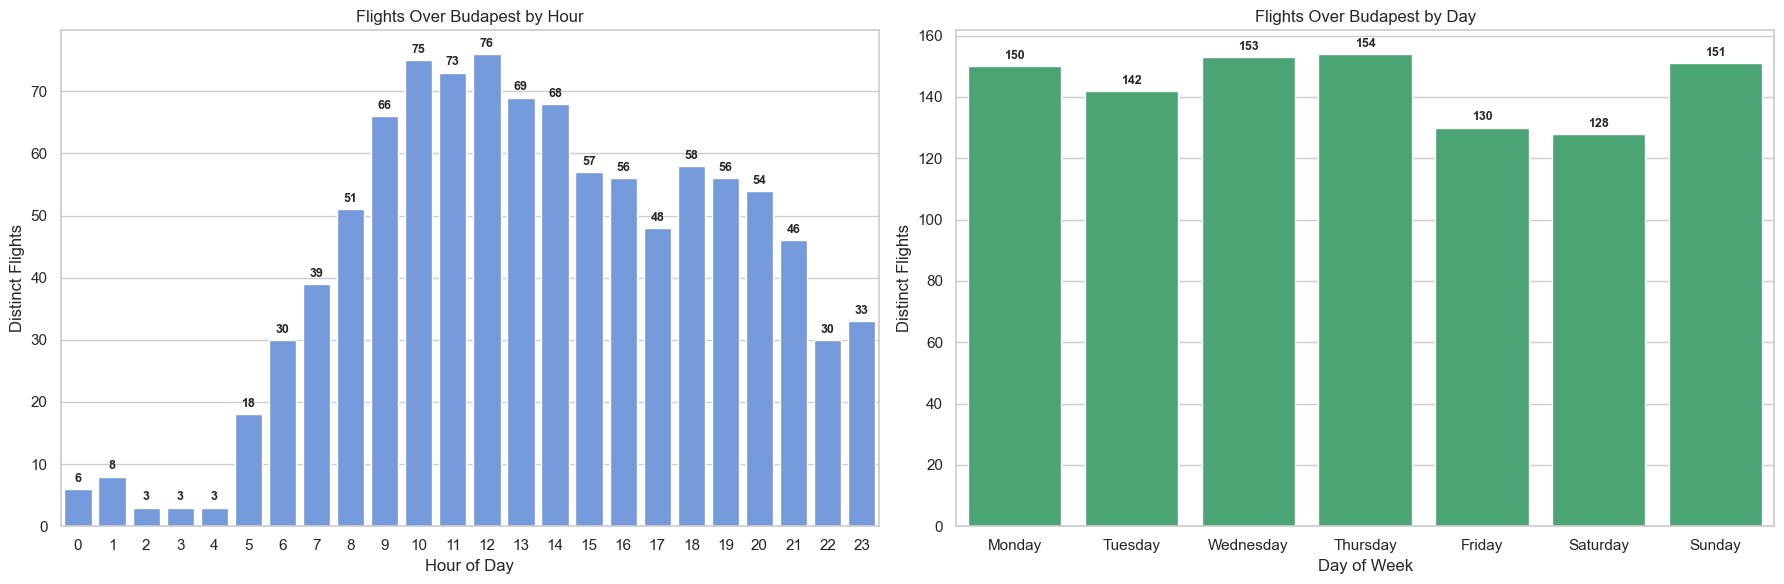

In [8]:
# Apply Seaborn's whitegrid style for clean visuals
sns.set(style='whitegrid')

# Create a figure with two horizontal subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# --- Left Plot: Distinct Flights by Hour of Day ---
sns.barplot(
    data=flights_by_hour,
    x='hour_of_day',
    y='distinct_flight_count',
    color='cornflowerblue',
    ax=axes[0]
)
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Distinct Flights')
axes[0].set_title('Flights Over Budapest by Hour')
axes[0].set_xticks(range(0, 24))  # Ensure all 24 hours are shown

# Annotate each bar with its value
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d', label_type='edge', padding=3, fontsize=9, weight='bold')

# --- Right Plot: Distinct Flights by Day of Week ---
sns.barplot(
    data=flights_by_day,
    x='day_of_week',
    y='distinct_flight_count',
    color='mediumseagreen',
    ax=axes[1]
)
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Distinct Flights')
axes[1].set_title('Flights Over Budapest by Day')

# Annotate each bar with its value
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%d', label_type='edge', padding=3, fontsize=9, weight='bold')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### 🧾 Summary and Limitations of the Analysis

This project demonstrates a geospatial analysis of flights over Budapest using data retrieved from the Flightradar24 API. While the methodology successfully identifies flights entering Budapest's airspace and visualizes their temporal patterns, the scope of the analysis is constrained by the cost and access limitations of the API.

Due to limited API credits, the dataset was restricted to a specific time window and geographic boundary. This constraint shaped the depth of the analysis, focusing primarily on spatial inclusion and temporal distribution.

With expanded access to the API, further insights could be explored, such as:
- Determining which flights landed at Budapest Airport versus those that only passed through the airspace.
- Classifying flights by type (e.g., commercial, cargo, private, military).
- Analyzing airline-specific traffic patterns or aircraft models.
- Tracking flight trajectories and durations for more dynamic movement analysis.

Despite these limitations, the project showcases a robust framework for integrating geospatial boundaries, temporal data, and flight metadata into a cohesive analytical pipeline.